In [1]:
%matplotlib notebook
from ipywidgets import *

from mag_manip.mag_manip import *
from scipy.spatial.transform import Rotation as R
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.transforms as mtransforms
import matplotlib.patches as patches
from matplotlib.collections import PatchCollection
from matplotlib import cm
import matplotlib as mpl
import numpy as np
import math
import yaml
from scipy.linalg import null_space

from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

from itertools import combinations

# Library for interval analysis

from interval import interval 
from interval import imath
from interval import fpu
from scipy.optimize import linprog
from pyibex import *

# Interval analysis for the determination of the workspace of an electromagnetic navigation system (eMNS)


The interval analysis method for the determination of 2d eMNS is adapted from the approch proposed in [Gouttefarde 2011](https://ieeexplore.ieee.org/document/5657268) for parallel cable-driven robot.

The feasibility must be verified using the strong solvability of the interval linear system using [Carretero 2016](https://cdnsciencepub.com/doi/abs/10.1139/tcsme-2016-0012) as the minimum boubds are negative.

Consist in using interval arithmetic to check boxes of space instead of individual poses

This is valid for linear model with dipole terms only.

**N.B.** This notebook requires the library [PyInterval](https://pyinterval.readthedocs.io/en/latest/index.html) and the [python binding](https://benensta.github.io/pyIbex/) of [ibex](http://www.ibex-lib.org/).


## Function for vizualisation

In [10]:
#Function for coils vizualisation

coil_length = 0.05
coil_width = 0.03

def Coils2DPatch(coil_length,coil_width,cal_path_mns):
    
    yaml_file = open(cal_path_mns)
    parsed_yaml_file = yaml.load(yaml_file, Loader=yaml.FullLoader)
    
    patches_list = []
    
    coil_list = parsed_yaml_file.get("Coil_List")
    n_coil = len(coil_list)
    
    #Iterate on coils
    for i in range(0,n_coil):
        
        #Get actual coil
        coil_i = parsed_yaml_file.get("Coil_"+str(i))
        n_sources = len(coil_i.get("Source_List"))
        

        #Iterate on sources for the coil
        for j in range(0,n_sources):

            #Get source parameters
            src_j = coil_i.get("Src_"+str(j))                           
            src_dir = src_j.get("Source_Direction")
            src_pos = src_j.get("Source_Position")

            #Transform position in source frame
            xpos = src_pos[0]
            ypos = src_pos[1]
            zpos = src_pos[2]
            
            angle = np.arctan2(src_dir[1],src_dir[0])
            
            #Coil
            coil = patches.Rectangle((0,0), coil_length,coil_width, color="black",  alpha=0.80)
            toff = mpl.transforms.Affine2D().translate(-coil_length/2,-coil_width/2)
            r = mpl.transforms.Affine2D().rotate_deg(angle*180/math.pi) 
            t = mpl.transforms.Affine2D().translate(xpos,ypos)
            coil.set_transform(toff + r + t)
            
            #Center
            center = patches.Circle((xpos, ypos), coil_width/10, color="blue",  alpha=1.)
            
            patches_list.append(coil)
            patches_list.append(center)

    
    p = PatchCollection(patches_list, alpha=0.4)
    
    return p

## Functions for intervals evaluation and workspace determination

In [11]:
def IntervalEvaluateVectorNorm(xi,yi,zi):

    # Compute norm
    inorm = imath.sqrt(xi**2 + yi**2 + zi**2)
    
    return inorm

def IntervalEvaluateNormalizedVector(xi,yi,zi):

    # Compute norm
    inorm = IntervalEvaluateVectorNorm(xi,yi,zi)
    
    # Compute component intervals
    xni = (xi / inorm) & interval[-1.,1.]
    yni = (yi / inorm) & interval[-1.,1.]
    zni = (zi / inorm) & interval[-1.,1.]

    return xni, yni, zni

def IntervalEvaluateLegendrePolyNomial(x,n):
    
    #LegendrePoly and derivative for order 0 to 2
    
    if n == 0:
        P = 1
        Pp = 0
    elif n == 1:
        P = x
        Pp = 1 
    elif n == 2:
        P = 0.5 * (3*x**2 - 1)
        Pp = 3*x
        
    return P, Pp

def IntervalEvaluateActuationMatrix(xi,yi,zi,parsed_yaml_file):
    
    coil_list = parsed_yaml_file.get("Coil_List")
    n_coil = len(coil_list)
    
    #Initialize interval actuation matrix
    Blist = [[0 for c in range(n_coil)] for r in range(2)]
    
    #Iterate on coils
    for i in range(0,n_coil):
        
        #Get actual coil
        coil_i = parsed_yaml_file.get("Coil_"+str(i))
        n_sources = len(coil_i.get("Source_List"))
        
        #Initialize coil contrib terms
        Bcoil_x = 0.
        Bcoil_y = 0.
        Bcoil_z = 0.

        #Iterate on sources for the coil
        for j in range(0,n_sources):

            #Get source parameters
            src_j = coil_i.get("Src_"+str(j))                         
            A = src_j.get("A_Coeff") #0 outside of the coils
            B = src_j.get("B_Coeff")  
            src_dir = src_j.get("Source_Direction")
            src_pos = src_j.get("Source_Position")

            #Transform position in source frame
            xs = (xi - src_pos[0])
            ys = (yi - src_pos[1])
            zs = (zi - src_pos[2])
            
            #Get norm from position vector for intervals
            
            rnorm = IntervalEvaluateVectorNorm(xs,ys,zs)
            xni, yni, zni = IntervalEvaluateNormalizedVector(xs,ys,zs)
            
            #Interval evaluation of cos from inclination angle
            gamma = (src_dir[0] * xni) + (src_dir[1] * yni) + (src_dir[2] * zni)
            
            #Consider only the dipole term
            P, Pp = IntervalEvaluateLegendrePolyNomial(gamma,1)
            C1 = - (2*B[0] / (rnorm ** 3))
            C2 = B[0] / (rnorm ** 3)
            
            
            #Simplified expression
            Bsrc_x = B[0] * (3 * gamma * xni - src_dir[0]) / (rnorm ** 3)
            Bsrc_y = B[0] * (3 * gamma * yni - src_dir[1]) / (rnorm ** 3)
            
            #Add source contribution to coil
            Bcoil_x = Bcoil_x + Bsrc_x
            Bcoil_y = Bcoil_y + Bsrc_y
    
        Blist[0][i] = Bcoil_x
        Blist[1][i] = Bcoil_y

    
    return Blist

### Utils combination matrix function

In [12]:
#Create combination matrix to test combination of field
def CreateFieldCombinationMatrix(n):

    nums = np.arange(2**n)
    M = ((nums.reshape(-1,1) & (2**np.arange(n))) != 0).astype(int)
    
    return M

### "Feasible" and "Out" routines

In [13]:
def Feasible(Ainter,Imin,Imax, bmin, bmax):
    
    #Ainter: the interval actuation matrix
    #Imin and Imax: the min and max available current
    #V: polytope representation of the desired available field
    
    d = np.shape(Ainter)[0]
    
    #Build the vertex matrices

    #Create combination matrix
    M = CreateFieldCombinationMatrix(d)
    Ytemp = 2*M-1
    Y = Ytemp.transpose()
    
    #print(Y)
    #print("\n")
    
    
    #Initialize feasability to True
    isFeasible = True
    
    #print(Ainter)
    #print("\n")
    
    for k in range(2**d):        
        #Initialization of the vertex matrix and vertex vector
        Ay = [[0 for c in range(len(Ainter[0]))] for r in range(d)]
        Amy = [[0 for c in range(len(Ainter[0]))] for r in range(d)]
        by = np.zeros((d,1))
        
        #Contruction
        for i in range(d):
            for j in range(len(Ainter[0])):
                Aij = Ainter[i][j]
                Ay[i][j] = Aij[0][0] + (Aij[0][1] - Aij[0][0])*(1 - Y[i,k])/2
                Amy[i][j] = Aij[0][0] + (Aij[0][1] - Aij[0][0])*(1 + Y[i,k])/2
                
       
            by[i] = bmin + (bmax - bmin) * (1 + Y[i,k])/2
        
        
        #Check strong solvability at the vertex using simplex method
        n = np.shape(Ainter)[1]
        c = np.zeros((2*n,1))
        A = np.concatenate((np.asarray(Ay), -np.asarray(Amy)), axis=1)
        b = by
        
        Imax_v = Imax * np.ones((n,1))
        Imin_v = -Imin * np.ones((n,1))
        beq = np.concatenate((Imax_v, Imin_v), axis=0)
        I = np.eye(n)
        Aeq_temp_up = np.concatenate((I, -I), axis=1)
        Aeq_temp_down = np.concatenate((-I, I), axis=1)
        Aeq = np.concatenate((Aeq_temp_up, Aeq_temp_down), axis=0)
        
        bnds = (0, None)
        
        try:
            res = linprog(c, Aeq, beq, A, b, bounds=(bnds))
            isVertexFeasible = res.success
        except:
            isVertexFeasible = False

        
        if not(isVertexFeasible):
            isFeasible = False
            break

    
    return isFeasible

def Out(Ainter,Imin,Imax, bmin, bmax):
    
    isOut = False
    
    d = np.shape(Ainter)[0]
    nc = len(Ainter[0])
    
    #Fetch the right function
    strDim = str(d) 
    strCoil = str(nc)  
    
    func_type = strDim + "D" + strCoil + "Coils.txt"
    
    f = Function(func_type)
    
    #Build contractor for equality constraint
    ctc = CtcFwdBwd(f, EQ)
             
    #Build interval matrix and interval vector
    i_list = []
    Ainter_list =[]
    #Build intervals

    for i in range(d):   
        for j in range(nc):
            Aij = Ainter[i][j]
            Ainter_list.append(Interval(Aij[0][0],Aij[0][1]))

    for k in range(nc):
        i_list.append(Interval(Imin,Imax))
    
    #Create combination matrix
    M = CreateFieldCombinationMatrix(d)
    Ytemp = 2*M-1
    Y = Ytemp.transpose()

    for k in range(2**d):        

        by_list = []

        #Contruction
        for i in range(d):
            byi = bmin + (bmax - bmin) * (1 + Y[i,k])/2
            by_list.append(Interval(byi,byi))

        #Build interval vector
        X = IntervalVector(tuple(i_list) + tuple(by_list) + tuple(Ainter_list))
        ctc.contract(X)
        
        #if one of the contracted interval is empty, the box is out
        if X.is_empty():
            isOut = True
            break

    return isOut

### Bisection and workspace computation methods

In [14]:
from itertools import product

def Create2DBox(xi,yi):

    #Initilialize
    Box = [[0 for c in range(1)] for r in range(2)]
    comb = product(np.arange(2),repeat=2)
    M = np.asarray(list(comb))  

    xmin = xi[0][0]
    xmax = xi[0][1]
    ymin = yi[0][0]
    ymax = yi[0][1]
    Box[0][0] = interval[xmin, xmax] 
    Box[1][0] = interval[ymin, ymax] 
    
    return Box

def BisectBox(Box):

    d = np.shape(Box)[0]

    #Initilialize
    Bb = [[0 for c in range(2)] for r in range(d)]
    comb = product(np.arange(2),repeat=d)
    M = np.asarray(list(comb))  

    #Divide each 1D-intervals
    for i in range(d): 
        inter = Box[i][0]
        xmin = inter[0][0]
        xmax = inter[0][1]
        Bb[i][0] = interval[xmin, (xmin+xmax)/2] 
        Bb[i][1] = interval[(xmin+xmax)/2, xmax] 

    #Create list of bisected boxes
    #Box list
    Box_list = []
    for i in range(2**d):
        B_temp = [[0 for c in range(1)] for r in range(d)]
        for j in range(d):  
            B_temp[j][0] = Bb[j][M[i,j]]
        #print(B_temp)
        Box_list.append(B_temp)
    
    return Box_list


def Ws2DDetermination(InitBox, bmin, bmax, Imin, Imax, eps, parsed_yaml_file,zoff,max_iter=-1):
    
    L = []
    Lin = []
    Lout = []
    Lneg = []
    L.append(InitBox)
    iteration = 0
        
    while(len(L)>0):
        #Extract intervals
        CurrentBox = L[0]
        del L[0] #remove the element from the list
        #Build interval matrix
        xi = CurrentBox[0][0]
        yi = CurrentBox[1][0]
        Ainter = IntervalEvaluateActuationMatrix(xi,yi,zoff,parsed_yaml_file)
        #Check feasbility
        isFeasible = Feasible(Ainter,Imin,Imax,bmin,bmax)

        if isFeasible:
            Lin.append(CurrentBox)
            #print('in')
        else:
            isOut = Out(Ainter,Imin,Imax,bmin,bmax)
            #isOut = False
            if isOut:
                Lout.append(CurrentBox)
                #print('out')
            else: 
                if (xi[0][1] - xi[0][0]) > eps and (yi[0][1] - yi[0][0]) > eps:
                    Bisected_box = BisectBox(CurrentBox)
                    L.extend(Bisected_box)
                else:
                    Lneg.append(CurrentBox)  
        iteration = iteration + 1
                
        if iteration >= max_iter and max_iter >= 1:
            print('Max iter reached')
            break
    
    return L, Lin, Lout, Lneg, iteration

## Application to a 2D example

In [15]:
# Load systems calibration
cal_path_mns = 'models/mns_2coils_90deg.yaml'
model_mns = ForwardModelMPEM()
model_mns.setCalibrationFile(cal_path_mns)

In [16]:
#Build initial box
pmin = -0.1
pmax = 0.1
xi = interval[pmin, pmax] 
yi = interval[pmin, pmax]
z = 0.
InitBox = Create2DBox(xi,yi)

#Define inputs interval and task set
Imin = -1
Imax = 1
bmin = -0.02
bmax = 0.02

#Load system model
yaml_file = open(cal_path_mns)
parsed_yaml_file = yaml.load(yaml_file, Loader=yaml.FullLoader)

#Define precision of bissection and run the determination algoritgm
eps = 0.005
L, Lin, Lout, Lneg, iteration = Ws2DDetermination(InitBox, bmin, bmax, Imin, Imax, eps, parsed_yaml_file,z)

<IPython.core.display.Javascript object>


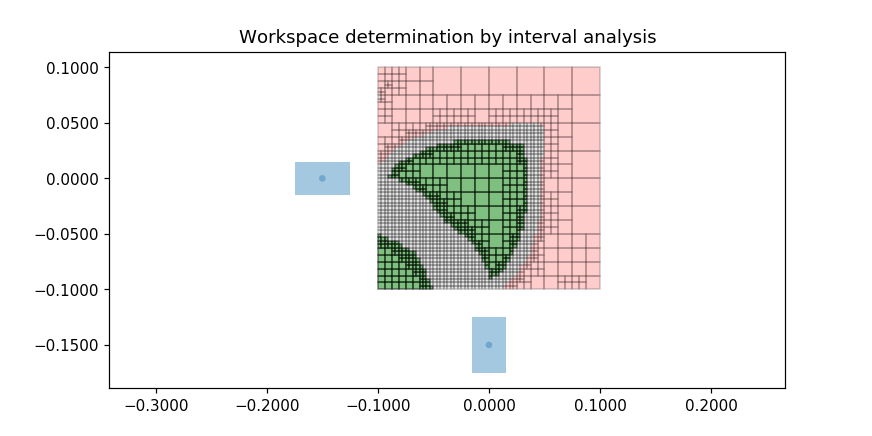

Text(0.5, 1.0, 'Workspace determination by interval analysis')

In [17]:
fig = plt.figure(figsize=(8, 4))

ax = fig.gca()

#Plot rectangle in
for i in range(len(Lin)):
    Box = Lin[i]
    xo = Box[0][0][0][0]
    yo = Box[1][0][0][0]
    dx = Box[0][0][0][1] - xo
    dy = Box[1][0][0][1] - yo
    rect = patches.Rectangle((xo,yo),dx,dy,linewidth=1,edgecolor='black',facecolor='green',alpha=0.5)
    ax.add_patch(rect)
    
#Plot rectangle undetermined
for i in range(len(Lneg)):
    Box = Lneg[i]
    xo = Box[0][0][0][0]
    yo = Box[1][0][0][0]
    dx = Box[0][0][0][1] - xo
    dy = Box[1][0][0][1] - yo
    rect = patches.Rectangle((xo,yo),dx,dy,linewidth=1,edgecolor='black',facecolor='gray',alpha=0.2)
    ax.add_patch(rect)
    
#Plot rectangle out
for i in range(len(Lout)):
    Box = Lout[i]
    xo = Box[0][0][0][0]
    yo = Box[1][0][0][0]
    dx = Box[0][0][0][1] - xo
    dy = Box[1][0][0][1] - yo
    rect = patches.Rectangle((xo,yo),dx,dy,linewidth=1,edgecolor='black',facecolor='red',alpha=0.2)
    ax.add_patch(rect)

#Plot coils
coll = Coils2DPatch(coil_length,coil_width,cal_path_mns)
ax.add_collection(coll)
 
#Plot figure
plt.show()
ax.axis('equal')
ax.set_title('Workspace determination by interval analysis')
